# Create monthly files for train-val-test sets
 Loads loads data for one month, performs data processing and save parquet file with results in specified S3 Bucket.
 Loads table with percentiles used for standarization

 0. Load libraries & data
 1. Functions for data processing 
 2. Create new variables 
 3. Standarize variables
 4. Create dummy variables 
 5. Create target label 
 6. Save data to S3 Bucket 

## Load libraries & data
Install & load python libraries
Load monthly data from ABT table
Load table with percentiles used for standarization

In [1]:
!pip install --upgrade pip
!pip install pyathena

In [2]:
#Set seaborn version
!pip install seaborn==0.12.2

In [3]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer 

In [4]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'analytics'


In [5]:
#Connection
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')

# Month of data to name the parket file that will be stored
mes_data = '202401' #812 secs
#Set to one for creating files for test and zero for train
archivo_test = 1

#df_ABT = pd.read_sql('''select * from analytics.abt_fraud_v2
#                            where date_receiver between cast('2023-12-01' as date) and cast('2023-12-15' as date);''', conn)

df_ABT = pd.read_sql('''select * from analytics.abt_v4
                            where date_receiver between cast('2024-01-01' as date) and cast('2024-02-01' as date);''', conn)

#Bring percentil table for data standarization
df_perc = pd.read_sql('''select * from analytics.percentiles_variables;''', conn)

/tmp/ipykernel_26822/226390782.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ABT = pd.read_sql('''select * from analytics.abt_v4
/tmp/ipykernel_26822/226390782.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_perc = pd.read_sql('''select * from analytics.percentiles_variables;''', conn)


In [6]:
df_perc

,variable,ptile,min,max
0,branch_minutes_since_last_transaction,1,-178.0,0.0
1,branch_working_days,1,-96.0,25.0
2,receiver_transaction_count,99,85.0,102.0
3,branch_minutes_since_last_transaction,99,1098.0,1385.0
4,sender_sending_days,99,552.0,560.0
5,net_amount_receiver,99,2275.0,2770.0
6,branch_working_days,99,5642.0,5867.0
7,net_amount_receiver,1,0.0,30.0
8,sender_sending_days,1,0.0,5.0
9,receiver_transaction_count,1,1.0,1.0


## Functions for data processing
 create_dummies & scale_percentils

In [7]:
def scale_percentils(data, Pmin, Pmax, calculo):
    """
    Define scale function

    Parameters:
    - data: Column to be scale.
    - calculo: Whether data is scale using min and max value or predefined value
    - Pmin: Value for inferior limit when calculo=0 or percentil for inferior limit when calculo=1 
    - Pmax: Value for superior limit when calculo=0 or percentil for superior limit when calculo=1 
    - calculo = 1 data is scaled using specified percentiles, Pmin & Pmax, as minimun and maximun
    - calculo = 0 data is scaled using values given by Pmin and Pmax values

    Returns:
    - dataN: scaled data
    """
    m = data.min()
    M = data.max()
    if calculo==1:
        Qmin = Pmin
        Qmax = Pmax
        q0 = data.quantile(Qmin)
        q1 = data.quantile(Qmax)
    elif calculo==0:
            q0=Pmin
            q1=Pmax
    data_std = (data - q0) / (q1 - q0)
    dataN =  data_std.to_numpy()
    #Set limits for outliers
    dataN = np.clip(dataN,0,1)
    return dataN

In [8]:
def create_dummies(df, todummy_list):
    """
    Create dummies from todummy_list list of variables

    Parameters:
    - df: dataframe with variables
    - todummy_list: list of variable names that will be converted to dummies

    Returns:
    - df: dataframe with new created columns
    - names: names of new columns that were created
    """
    df0 = df.copy()
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, axis = 1)
        df = pd.concat([df, dummies], axis=1)
        df = pd.DataFrame(df)
    return df, df.columns.difference(df0.columns)

## Create new variables
 01_isMexico & 01_sender_branch_state <br>
 01_isCashPick & 01_isBankDep <br>
 sender_days_to_last_transaction_365 & sender_days_to_last_transaction_more365 <br>
 sender_days_to_last_transaction_7m & sender_days_to_last_transaction_more7m <br>
 sender_minutes_since_last_transaction_2days 6 sender_minutes_since_last_transaction_1day <br>


In [9]:
#Create variables from date_receiver
df_ABT['mes'] = df_ABT['date_receiver'].dt.month
df_ABT['hour_receiver'] = df_ABT['date_receiver'].dt.hour
df_ABT['day_name_receiver'] = df_ABT['date_receiver'].dt.weekday

In [10]:
#If transaction is to Mexico
df_ABT['01_isMexico'] = (df_ABT['id_country_receiver_claim'].str.strip() =='MEX')
#If sender state is the same as branch state
df_ABT['01_sender_branch_state'] = (df_ABT['sender_state'].str.strip() == df_ABT['id_state'].str.strip())
#Variance with historical net_amount_receiver for sender
df_ABT['01_var_range_hist'] = df_ABT['net_amount_receiver'].astype(float) / df_ABT['range_hist']
#Whether receiver had fraud-not reliable
df_ABT['01_receiver_fraud'] = (df_ABT['receiver_has_fraud']>0)
#Whether branch/location/sender had fraud in the past
df_ABT['01_branch_fraud'] = (df_ABT['branch_has_fraud']>0)
df_ABT['01_location_fraud'] = (df_ABT['location_nro_fraud']>0)
df_ABT['01_sender_fraud'] = (df_ABT['sender_nro_fraud']>0)


In [11]:
#Whether transaction is Cash Pick-up or Bank Deposit
cash_payout = ['M','P','S'] #id_payout for Cash Pick-up
bankdp_payout =['C','N','X','T'] #id_payout for Bank Deposit

df_ABT['01_isCashPick'] = df_ABT.id_payout.isin(cash_payout)
df_ABT['01_isBankDep'] = df_ABT.id_payout.isin(bankdp_payout)
#df_ABT[['01_isCashPick','id_payout','01_isBankDep']]

In [12]:
#Count days to last transaction only for one year and if dummy variable if not
df_ABT['sender_days_to_last_transaction'] = df_ABT['sender_days_to_last_transaction'].abs()
df_ABT.loc[:,'sender_days_to_last_transaction_365'] = df_ABT['sender_days_to_last_transaction']
df_ABT.loc[:,'sender_days_to_last_transaction_more365'] = 0
df_ABT.loc[df_ABT['sender_days_to_last_transaction']> 365, 'sender_days_to_last_transaction_more365'] = 1
df_ABT.loc[df_ABT['sender_days_to_last_transaction']> 365, 'sender_days_to_last_transaction_365'] = 0 

#Count days to last transaction only for 7 months(suggested by them) and if dummy variable if not
df_ABT.loc[:,'sender_days_to_last_transaction_7m'] = df_ABT['sender_days_to_last_transaction']
df_ABT.loc[:,'sender_days_to_last_transaction_more7m'] = 0
df_ABT.loc[df_ABT['sender_days_to_last_transaction']> 7*30, 'sender_days_to_last_transaction_more7m'] = 1
df_ABT.loc[df_ABT['sender_days_to_last_transaction']> 7*30, 'sender_days_to_last_transaction_7m'] = 0 

In [13]:
#Minutes till last transaction only for one or two days 
df_ABT.loc[:, 'sender_minutes_since_last_transaction_2days'] = df_ABT['sender_minutes_since_last_transaction']
df_ABT.loc[:, 'sender_minutes_since_last_transaction_1day'] = df_ABT['sender_minutes_since_last_transaction']

df_ABT.loc[df_ABT['sender_minutes_since_last_transaction']> 2*24*60, 'sender_minutes_since_last_transaction_2days'] = 0
df_ABT.loc[df_ABT['sender_minutes_since_last_transaction']> 24*60, 'sender_minutes_since_last_transaction_1day'] = 0

## Standarize variables
sender_days_to_last_transaction_365, sender_minutes_since_last_transaction_2days, net_amount_receiver, sender_sending_days, branch_working_days, receiver_transaction_count

In [14]:
#New Variables
df_ABT['branch_trans_3m']
df_ABT['sender_trans_3m']

df_ABT['location_nro_fraud']
df_ABT['branch_has_fraud']
df_ABT['sender_nro_fraud']
df_ABT['branch_trans_40min']
df_ABT['branch_trans_10min']
df_ABT['receiver_transaction_count']
df_ABT['sender_sending_days']
df_ABT['branch_working_days']
df_ABT['net_amount_receiver']

0          2000.0
1          1500.0
2           240.0
3          1000.0
4            88.0
            ...  
2076901     800.0
2076902      90.0
2076903     250.0
2076904     250.0
2076905    2000.0
Name: net_amount_receiver, Length: 2076906, dtype: float64

In [15]:
df_ABT.loc[np.isnan(df_ABT.receiver_transaction_count),'receiver_transaction_count'] = 0
df_ABT.loc[np.isnan(df_ABT.branch_working_days),'branch_working_days'] = 0

In [16]:
Mx = df_perc.loc[(df_perc['variable']=='receiver_transaction_count') & (df_perc['ptile']==99),'max'].item()
mn = df_perc.loc[(df_perc['variable']=='receiver_transaction_count') & (df_perc['ptile']==1),'min'].item()
Mx = int(Mx)
mn = int(mn)

df_ABT['01_receiver_transaction_count'] = scale_percentils(df_ABT['receiver_transaction_count'].astype(int), mn, Mx, 0)

In [17]:
df_perc[df_perc['variable']=='receiver_transaction_count']

,variable,ptile,min,max
2,receiver_transaction_count,99,85.0,102.0
9,receiver_transaction_count,1,1.0,1.0


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_receiver_transaction_count', ylabel='Count'>

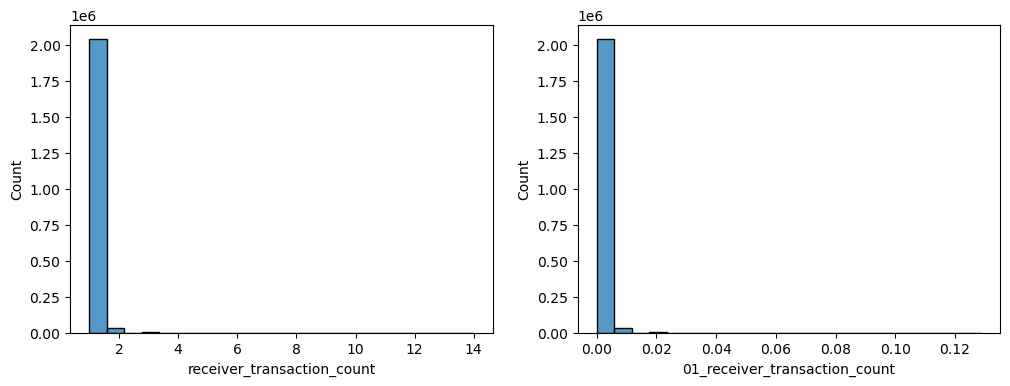

In [18]:
#df_ABT['receiver_transaction_count'] = df_ABT['receiver_transaction_count'].astype(int)
fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_ABT, x="receiver_transaction_count", ax = axs[0])
sns.histplot(data=df_ABT, x="01_receiver_transaction_count", ax = axs[1])

In [19]:
Mx = df_perc.loc[(df_perc['variable']=='sender_sending_days') & (df_perc['ptile']==99),'max'].item()
mn = df_perc.loc[(df_perc['variable']=='sender_sending_days') & (df_perc['ptile']==1),'min'].item()
Mx = int(Mx)
mn = int(mn)

df_ABT['01_sender_sending_days'] = scale_percentils(df_ABT['sender_sending_days'], mn, Mx, 0)

In [20]:
df_perc[df_perc['variable']=='sender_sending_days']

,variable,ptile,min,max
4,sender_sending_days,99,552.0,560.0
8,sender_sending_days,1,0.0,5.0


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_sender_sending_days', ylabel='Count'>

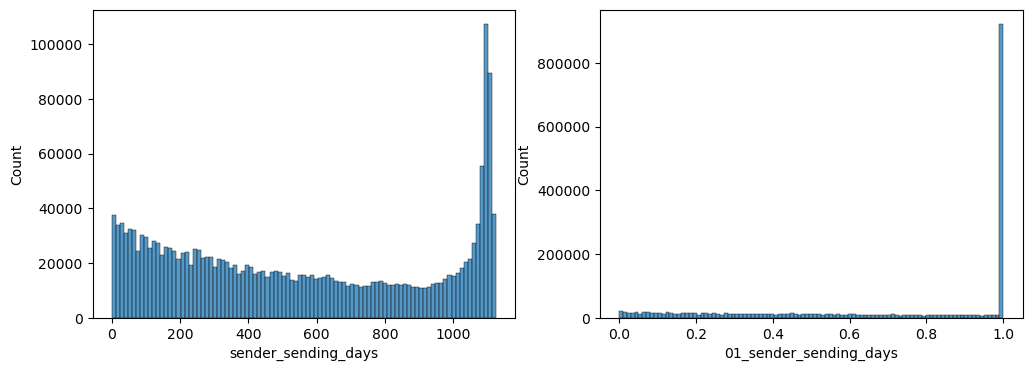

In [21]:
fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_ABT, x="sender_sending_days", ax = axs[0])
sns.histplot(data=df_ABT, x="01_sender_sending_days", ax = axs[1])

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 100000.0)

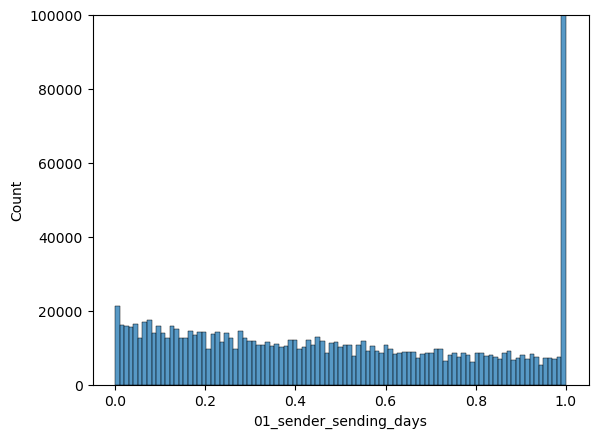

In [22]:
sns.histplot(data=df_ABT, x="01_sender_sending_days")
plt.ylim(0,100000)

In [23]:
#Standarize rest of the variables
Mx = df_perc.loc[(df_perc['variable']=='receiver_transaction_count') & (df_perc['ptile']==99),'max'].item()
mn = df_perc.loc[(df_perc['variable']=='receiver_transaction_count') & (df_perc['ptile']==1),'min'].item()

Mx = int(Mx)
mn = int(mn)

df_ABT['01_receiver_transaction_count'] = scale_percentils(df_ABT['receiver_transaction_count'].astype(int), mn, Mx, 0)

Mx = df_perc.loc[(df_perc['variable']=='branch_working_days') & (df_perc['ptile']==99),'max'].item()
mn = df_perc.loc[(df_perc['variable']=='branch_working_days') & (df_perc['ptile']==1),'min'].item()
Mx = int(Mx)
mn = int(mn)

df_ABT['01_branch_working_days'] = scale_percentils(df_ABT['branch_working_days'].astype(int), mn, Mx, 0)

Mx = df_perc.loc[(df_perc['variable']=='net_amount_receiver') & (df_perc['ptile']==99),'max'].item()
mn = df_perc.loc[(df_perc['variable']=='net_amount_receiver') & (df_perc['ptile']==1),'min'].item()
Mx = float(Mx)
mn = float(mn)

df_ABT['01_net_amount_receiver'] = scale_percentils(df_ABT['net_amount_receiver'].astype(float), mn, Mx, 0)

Mx = 2880
mn = 0
df_ABT['01_sender_minutes_since_last_transaction_2days'] = scale_percentils(df_ABT['sender_minutes_since_last_transaction_2days'], mn, Mx, 0)

Mx = 1440
mn = 0
df_ABT['01_sender_minutes_since_last_transaction_1day'] = scale_percentils(df_ABT['sender_minutes_since_last_transaction_1day'], mn, Mx, 0)

Mx = 365
mn = 0
df_ABT['01_sender_days_to_last_transaction_365'] = scale_percentils(df_ABT['sender_days_to_last_transaction_365'].abs(), mn, Mx, 0)

Mx = 7*30
mn = 0
df_ABT['01_sender_days_to_last_transaction_7m'] = scale_percentils(df_ABT['sender_days_to_last_transaction_7m'].abs(), mn, Mx, 0)

Mx = 24
mn = 0
df_ABT['01_hour_receiver'] = scale_percentils(df_ABT['hour_receiver'], mn, Mx, 0)

In [24]:
#df_ABT['01_receiver_transaction_count'].describe()
#df_ABT['01_sender_sending_days'].describe()
#df_ABT['01_branch_working_days'].describe()
#df_ABT['01_net_amount_receiver'].describe()
#df_ABT['01_sender_minutes_since_last_transaction_2days'].describe()
#df_ABT['01_sender_minutes_since_last_transaction_1day'].describe()
#df_ABT['01_sender_days_to_last_transaction_365'].describe()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_sender_days_to_last_transaction_365', ylabel='Count'>

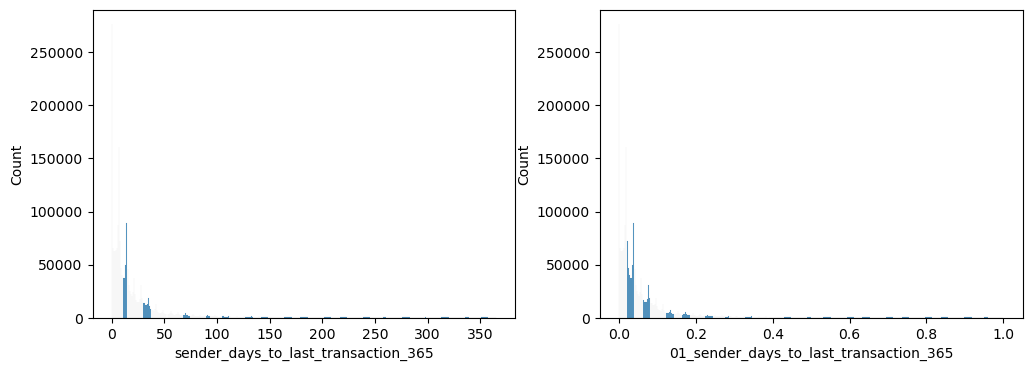

In [25]:
fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_ABT, x="sender_days_to_last_transaction_365", ax = axs[0])
sns.histplot(data=df_ABT, x="01_sender_days_to_last_transaction_365", ax = axs[1])

## Create dummy variables

In [26]:
todummy_list = ['day_name_receiver','id_payout']
[df_ABT, var_nuevas] = create_dummies(df_ABT, todummy_list)

## Create target label

In [27]:
#Standarize fraud_type 
df_ABT['fraud_type'] = df_ABT['fraud_type'].str.capitalize()
df_ABT['fraud_type'].value_counts()

fraud_type
Payment    23
Viatab      3
Name: count, dtype: int64

In [28]:
# defino los targets
df_ABT['targetR'] = df_ABT['fraud_type'] == 'Remote access'
df_ABT['targetP'] = df_ABT['fraud_type'] == 'Payment'
df_ABT['target_fraudes'] = df_ABT['fraud_type'].notnull()


In [29]:
df_ABT['targetR'].value_counts()

targetR
False    2076906
Name: count, dtype: int64

In [30]:
df_ABT['targetP'].value_counts()

targetP
False    2076883
True          23
Name: count, dtype: int64

In [31]:
df_ABT['target_fraudes'].value_counts()

target_fraudes
False    2076880
True          26
Name: count, dtype: int64

In [32]:
df_ABT.columns.values

array(['id_branch', 'id_receiver', 'date_receiver', 'id_location',
       'id_payer', 'id_sender_global', 'net_amount_receiver',
       'receiver_transaction_count', 'id_country_receiver_claim',
       'id_state_receiver_claim', 'id_state', 'branch_working_days',
       'sender_sending_days', 'sender_days_to_last_transaction',
       'id_country', 'fraud_classification',
       'sender_minutes_since_last_transaction',
       'branch_minutes_since_last_transaction',
       'sender_days_since_last_transaction', 'fraud_type',
       'fraud_classification_2', 'id_country_receiver', 'id_payment',
       'id_state_receiver', 'id_city_receiver', 'bank_receiver',
       'branch_trans_3m', 'sender_state', 'day', 'branch_has_fraud',
       'receiver_has_fraud', 'branch_trans_40min', 'branch_trans_10min',
       'cash_pick_up_40min', 'location_nro_fraud', 'sender_trans_3m',
       'range_hist', 'sender_nro_fraud', 'mes', 'hour_receiver',
       '01_isMexico', '01_sender_branch_state', '01_var_ran

## Save files to S3 Bucket

In [33]:
#Keep variables used in the model
df_ABT.columns.values
df = df_ABT.drop(columns=[ 'fraud_type','fraud_classification_2','id_country_receiver',
       'id_payment', 'id_state_receiver', 'id_city_receiver', 'bank_receiver','day',
        'targetR','targetP','target_fraudes'])

#df = pd.concat([df, df_ABT[var_nuevas]], axis=1)
df = pd.concat([df, df_ABT[['targetR','targetP','target_fraudes']]], axis=1)


In [34]:
import os
import pyarrow as pa
import pyarrow.parquet as pq

In [35]:
if archivo_test == 0:
    s3_url = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Train/Preproc_Fr_{mes_data}.parquet"
elif archivo_test ==1:
    s3_url = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Test/Preproc_Fr_{mes_data}.parquet"
#df.to_parquet(path='./exp1.parquet', engine='pyarrow', compression='gzip')
df.to_parquet(path=s3_url, engine='pyarrow', compression='gzip')
print('finish saving parquet')

finish saving parquet


In [36]:
df.head(5)

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,...,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target_fraudes
0,A23227,1676,2024-01-27 17:50:08.033,KS0116,NN,11319682,2000.0,1,HON,HON03,...,False,False,False,True,False,False,False,False,False,False
1,A00366,54925,2024-01-03 12:33:31.427,TX0386,NN,7689811,1500.0,1,MEX,MEX45,...,False,False,False,True,False,False,False,False,False,False
2,A04449,84273,2024-01-20 11:32:58.743,MD0325,NN,7089243,240.0,1,ELS,ELS03,...,False,False,False,False,False,False,False,False,False,False
3,A22064,6645,2024-01-12 09:39:18.910,NY1215,NN,10591780,1000.0,1,GUA,GUA6,...,False,False,False,True,False,False,False,False,False,False
4,A22431,39666,2024-01-25 19:43:45.690,AZ0166,NN,10435949,88.0,1,MEX,MEX33,...,False,False,False,False,False,False,False,False,False,False


In [37]:
mes_data

'202401'